# Zogy PSF and matching kernel of Gaussian image PSFs
We do numerical intergration on the Gaussian input PSF case and produce some visualization plots about the matching kernels and the PSF of the difference image.

### Notation:

$N_1$, $N_2$: Input images.

$c_1$, $c_2$: Matching kernels for the input images $N_1$ and $N_2$.

$P_1$, $P_2$: PSFs of the input images $N_1$ and $N_2$.

$P_d$ : the PSF of the difference image, the result of the PSF matching for both images.

$\sigma_1$, $\sigma_2$: The PSF sigma (width) of Gaussian image PSFs in _image space_.

We use the terms "Fourier space" and "image space".

--------

All quantities are in Fourier space unless stated otherwise. In Fourier space, same noise level, same photometric calibration in the two input images, the Zogy difference image can be written as:

$$D = \frac{P_2}
{\sqrt{|P_2|^2 + |P_1}|^2}
N_1 - \frac{P_1}
{\sqrt{|P_2|^2 + |P_1|^2}} N_2
= c_1 N_1 - c_2 N_2$$


Having a PSF:
$$P_d = \sqrt{2}\frac{P_1 P_2}{\sqrt{|P_1|^2 + |P_2|^2}}$$ 

In general, the Fourier transforms are complex quantities. Assuming Gaussian PSF-s, the Fourier transforms are all real (Fourier transform of even, all real functions) and positive, so we can omit the absolute values and write:

$$c_1 = \frac{1}{\sqrt{1 + \left(\frac{P_1}{P_2}\right)^2}}$$

Consider the limit properties of this expression depending on the width of P1, P2

$$P_d = \frac{\sqrt{2}}{\sqrt{\frac{1}{P_1^2} + \frac{1}{P_2^2}}}$$

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.integrate as s_int
import numpy as np
import sympy as sp

In [2]:
pi2 = np.pi * np.pi

In [3]:
x, k = sp.symbols('x k', real=True)
s1, s2 = sp.symbols('sigma1 sigma2', positive=True)

In [4]:
# Normalized PSF in 1D in real space
# The normalized 2D PSF is the product of two 1D
gPsf = 1/(sp.sqrt(2*sp.pi)*s1)*sp.exp(-x**2/(2*s1**2))
display(gPsf)

sqrt(2)*exp(-x**2/(2*sigma1**2))/(2*sqrt(pi)*sigma1)

In [5]:
# The Fourier transform of the Gaussian PSF
ftPsf = sp.fourier_transform(gPsf, x, k)
display(ftPsf)

exp(-2*pi**2*k**2*sigma1**2)

### $\sigma_1=1$, $\sigma_2=2$
Get the callable functions after sigma substitution by "lambdify"

In [6]:
# f1 : the numerical function for PSF1 in Fourier space
# r1 : the numerical function for PSF1 in real space
f1 = ftPsf.subs({s1 : 1})
r1 = gPsf.subs({s1 : 1})
display(f1)
display(r1)
f1 = sp.lambdify(k, f1)
r1 = sp.lambdify(x, r1)

exp(-2*pi**2*k**2)

sqrt(2)*exp(-x**2/2)/(2*sqrt(pi))

In [7]:
f2 = ftPsf.subs({s1 : 2})
display(f2)
r2 = gPsf.subs({s1 : 2})
display(r2)
f2 = sp.lambdify(k, f2)
r2 = sp.lambdify(x, r2)

exp(-8*pi**2*k**2)

sqrt(2)*exp(-x**2/8)/(4*sqrt(pi))

In [8]:
# P2/P1 and P1/P2 in Fourier space
df21 = ftPsf.subs({s1 : 2}) / ftPsf.subs({s1 : 1})
display(df21)
df12 = 1/df21
display(df12)
df21 = sp.lambdify(k, df21)
df12 = sp.lambdify(k, df12)

exp(-6*pi**2*k**2)

exp(6*pi**2*k**2)

## The PSFs and matching kernels in Fourier space.

Let's see how the matching kernels c1, c2 look like. Direct numerical integration of the formulas above. 

The matching kernel for one of the images goes to zero, and to const for the other one.

Depending whether $P_2/P_1$ or $P_1/P_2$ has positive or negative exponent. The negative exponent gives a Gaussian-like matching kernel, the constant-like gives a dirac-delta minus a Gaussian like (consider the Fourier space function as a constant minus a Gaussian-like curve). 

<IPython.core.display.Javascript object>


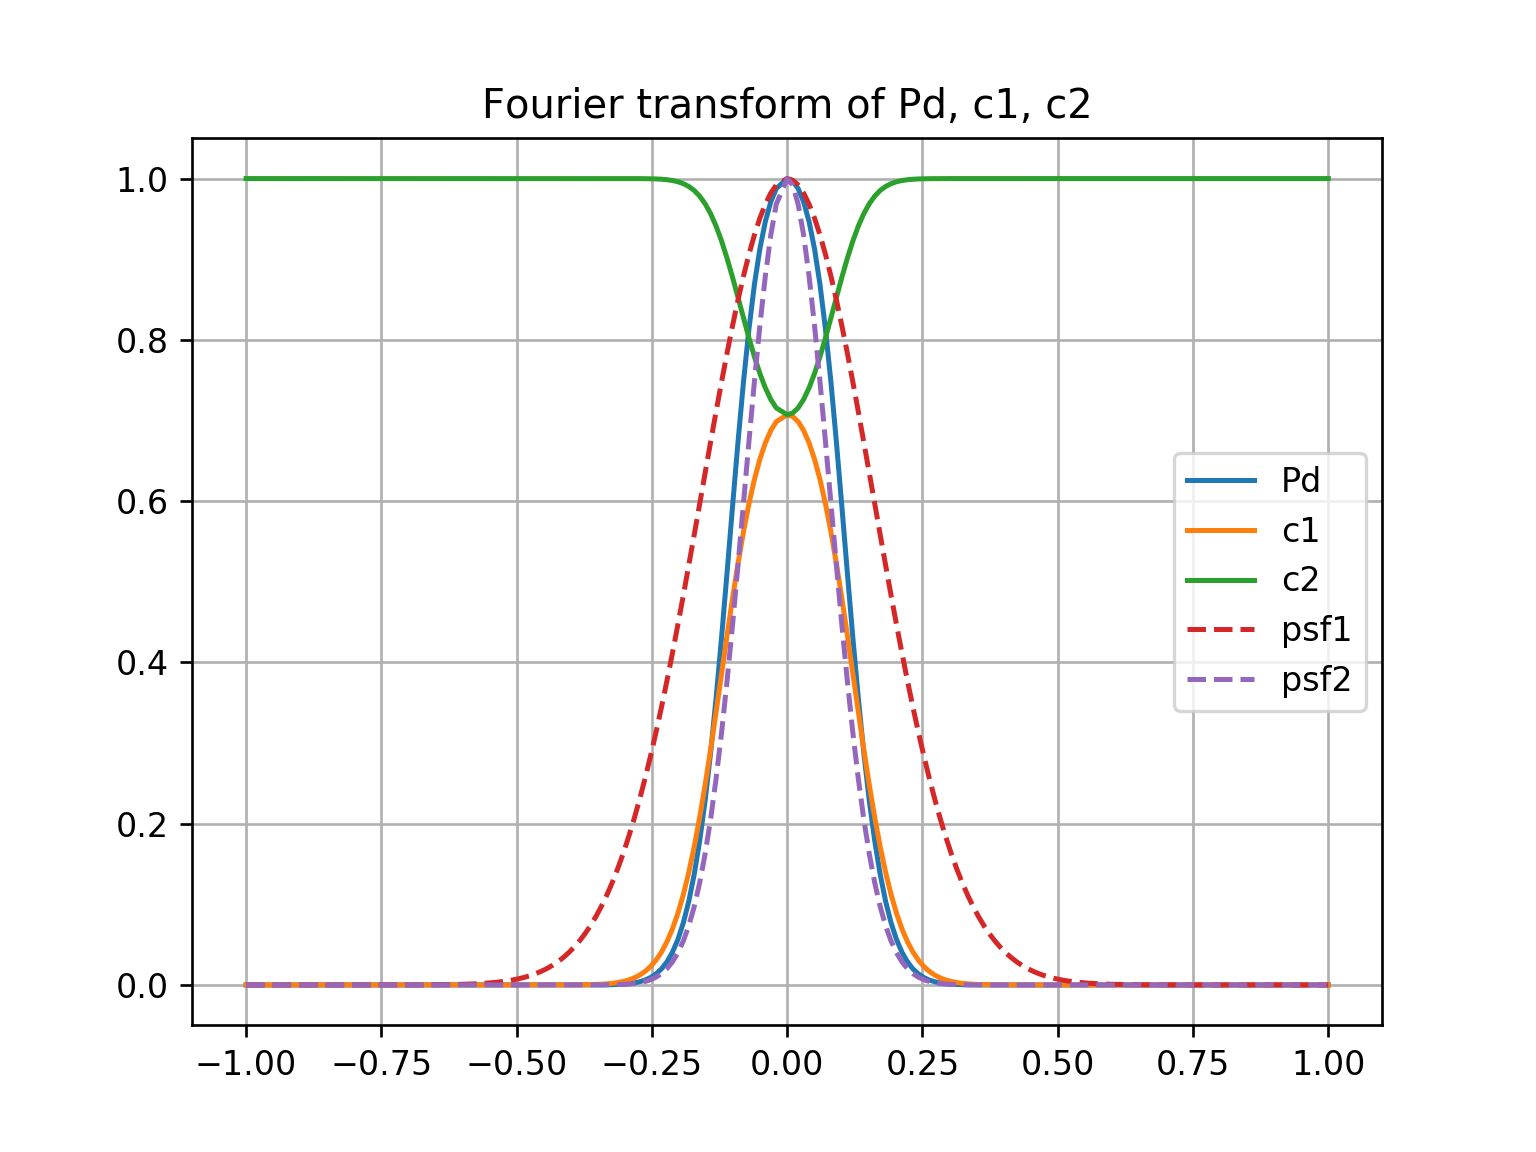

Text(0.5, 1.0, 'Fourier transform of Pd, c1, c2')

In [9]:
# Show the Fourier transformed PSFs along the x axis. All is all real.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
W = np.linspace(0, 1, 100)
W2 = np.concatenate((-W[:1:-1],W))
ax.plot(W2, np.sqrt(2/((f1(W2)**2 * f1(0)**2) + 1/(f2(W2)**2 * f2(0)**2))), '-', label='Pd')
ax.plot(W2, 1/np.sqrt(1 + df12(W2)**2 * df12(0)**2), '-', label='c1')
ax.plot(W2, 1/np.sqrt(1 + df21(W2)**2 * df21(0)**2), '-', label='c2')
ax.plot(W2, f1(W2)*f1(0), '--', label='psf1')
ax.plot(W2, f2(W2)*f2(0), '--', label='psf2')
ax.legend()
ax.grid()
ax.set_title("Fourier transform of Pd, c1, c2")

In [10]:
fig.savefig("zogy_theo_Gaussians_ft_Pd_c1_c2.pdf")

## The PSFs and matching kernels in Image space.

Let's numerically (inverse) Fourier transform Pd

The 2D Gaussians are the product of the per-axis Gaussians here

### Pd

In [11]:
# The (inverse) Fourier-transform that we want to calculate only at k_y = 0.
# Here the integration goes over y, x.
# The function is symmetric -> only the cosine term matters (exp(1j*x) = cos(x) + 1j*sin(x))
def f2d(y, x, k_x):
    return np.sqrt(2)*np.cos(2*np.pi*k_x*x)/np.sqrt(1/(f1(x)**2 * f1(y)**2) + 1/(f2(x)**2 * f2(y)**2))
W = np.linspace(0., 10, 100)
D = [s_int.dblquad(lambda y, x:f2d(y, x, w), -10, 10, -10, 10)[0] for w in W]

/ssd/gkovacs/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/ssd/gkovacs/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """


In [12]:
# Let's have a negative side as well
W2 = np.concatenate((-W[:1:-1],W))
D2 = np.concatenate((D[:1:-1],D))

<IPython.core.display.Javascript object>


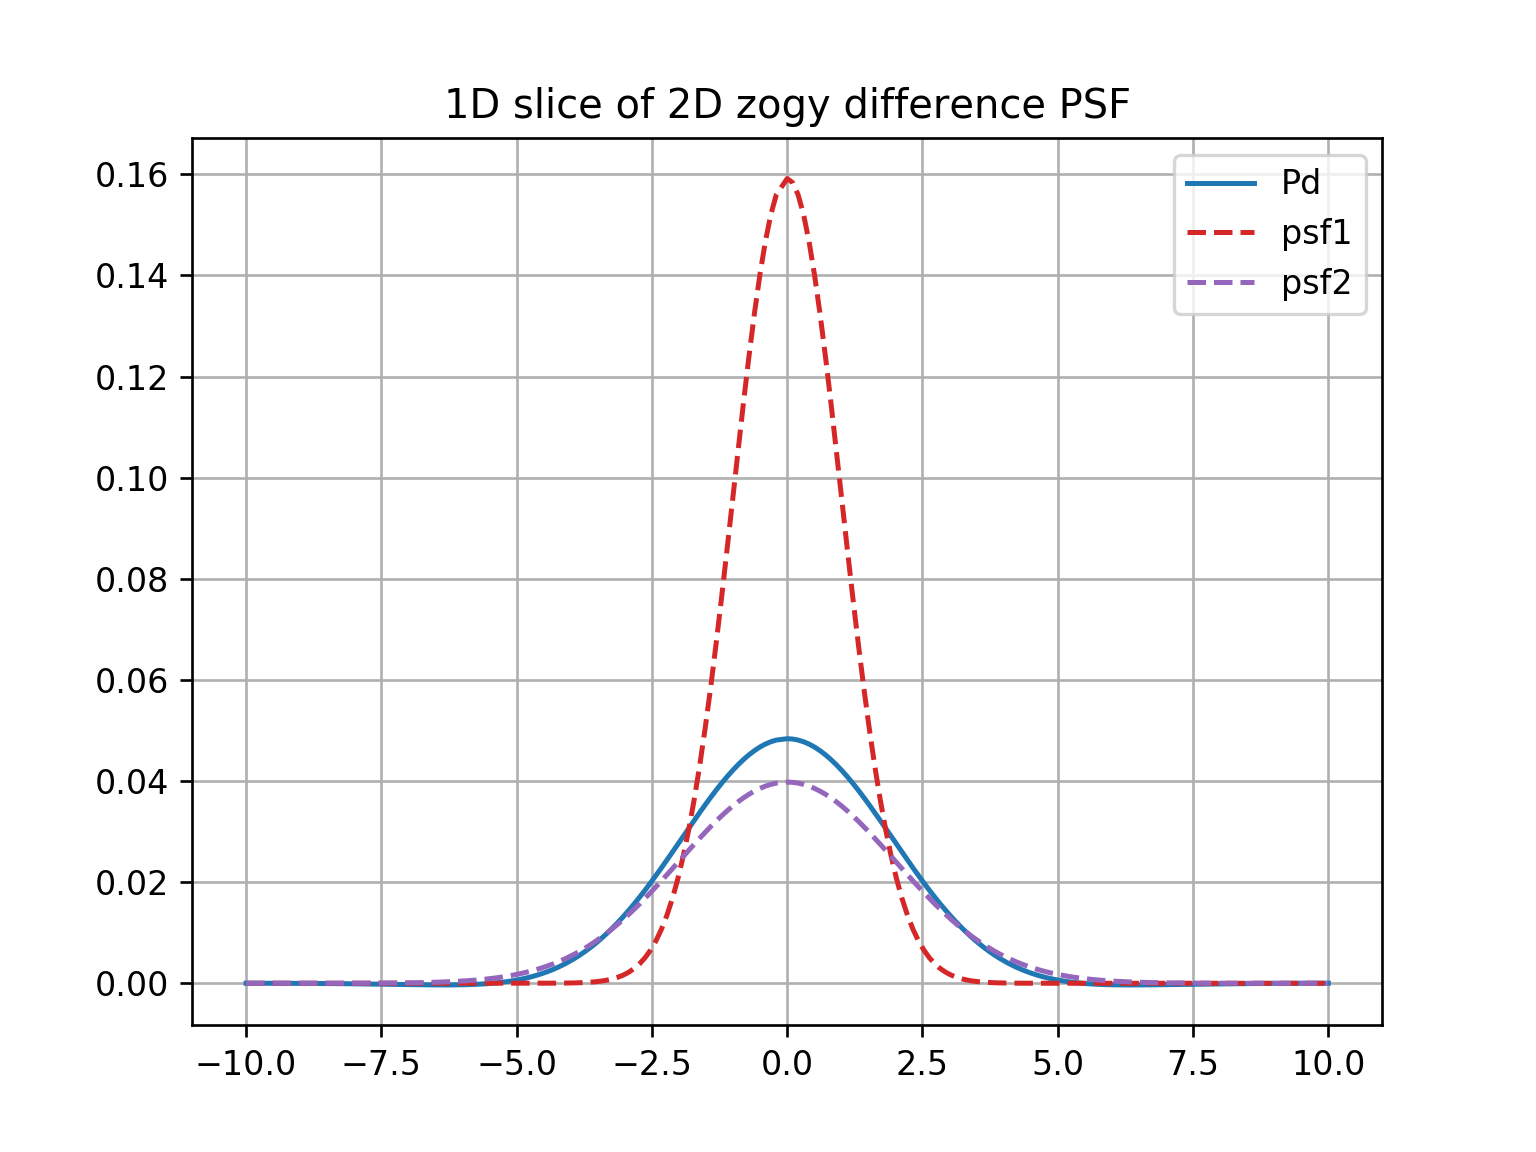

In [13]:
# Show the (inverse) Fourier transformed 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(W2, D2, '-', label='Pd')
ax.plot(W2, r1(W2)*r1(0), '--', color='C3', label='psf1')
ax.plot(W2, r2(W2)*r2(0), '--', color='C4', label='psf2')
ax.legend()
ax.set_title("1D slice of 2D zogy difference PSF")
ax.grid()

In [14]:
fig.savefig("zogy_theo_Gaussians_img_Pd.pdf")

<IPython.core.display.Javascript object>


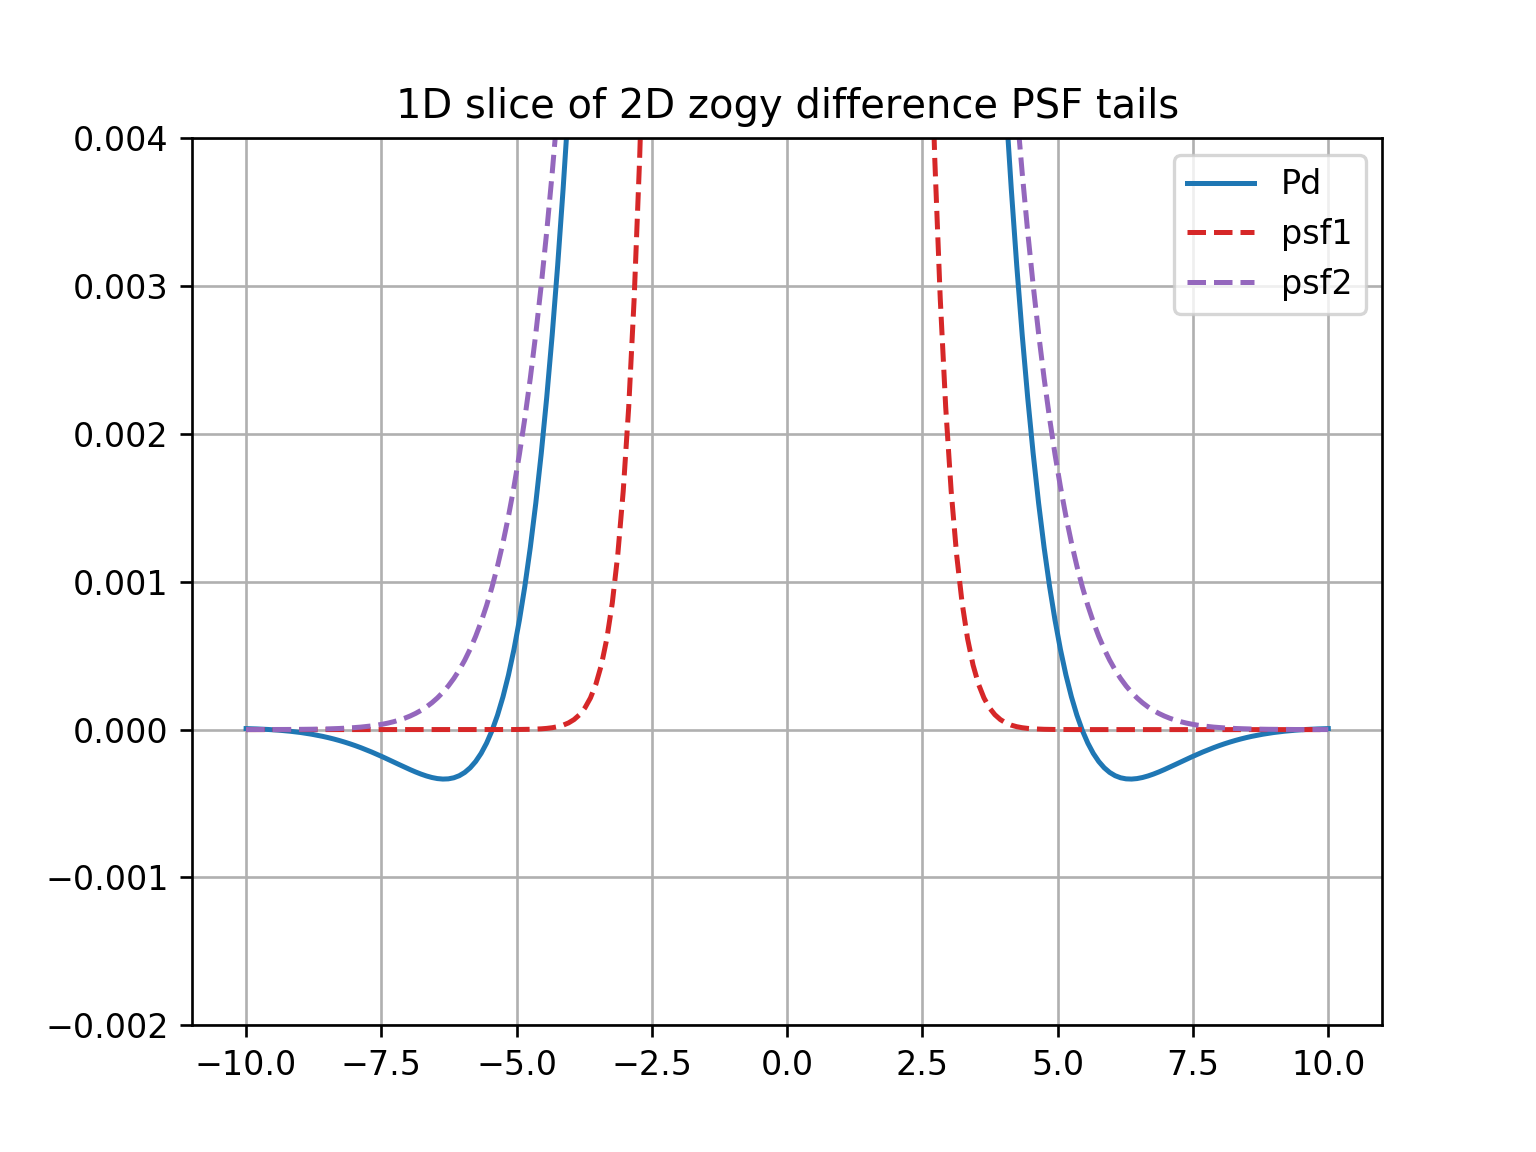

Text(0.5, 1.0, '1D slice of 2D zogy difference PSF tails')

In [15]:
# Show the (inverse) Fourier transformed 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(W2, D2, '-', label='Pd')
ax.plot(W2, r1(W2)*r1(0), '--', color='C3', label='psf1')
ax.plot(W2, r2(W2)*r2(0), '--', color='C4', label='psf2')
ax.legend()
ax.grid()
ax.set_ylim(-0.002, 0.004)
ax.set_title("1D slice of 2D zogy difference PSF tails")

In [16]:
fig.savefig("zogy_theo_Gaussians_img_Pd_tails.pdf")

### Check Pd's "sigma" based on FWHM
Based on the FWHM, estimate how wide is the ZOGY difference image PSF solution.

$$F = 2\sigma\sqrt{2\ln 2}$$

In [18]:
# Pd's half width at half max is about 2.24 based on the figure
# Estimate it's "effective sigma" 
2.24/np.sqrt(2*np.log(2))

1.902480832645163

In [19]:
# Compare to the cross-convolution of images 
# np.sqrt(2**2 + 1**2) = np.sqrt(5)
np.sqrt(5)

2.23606797749979

In a more precise way, search for the half width of D:

In [20]:
D = np.array(D)
halfV = D[0]/2.
# Cut D at its (first) zero crossing
flt = D > 0
i = np.flatnonzero(flt[:-1] & ~flt[1:])[0]
X = D[:i+1]
i2 = i - np.searchsorted(X[::-1], halfV) # i2 is an index in D

In [21]:
halfWidth = (W[i2] + W[i2+1])*0.5

In [22]:
Dsigma = halfWidth / np.sqrt(2*np.log(2))

In [23]:
print(f"Dsigma: {Dsigma}, Quad sum:{np.sqrt(5)}")

Dsigma: 1.9109740506480428, Quad sum:2.23606797749979


The result is "narrower" but close to the wider input PSF sigma.

---------

### c1

In [24]:
# The (inverse) Fourier-transform that we want to calculate only at k_y = 0
# The function is symmetric -> only the cosine term matters (exp(1j*x) = cos(x) + 1j*sin(x))
def c12d(y, x, k_x):
    return np.cos(2*np.pi*k_x*x)/np.sqrt(df12(x)**2 * df12(y)**2 + 1)
W = np.linspace(0, 10, 100)
D = [s_int.dblquad(lambda y, x:c12d(y, x, w), -10, 10, -10, 10)[0] for w in W]

<string>:2: RuntimeWarning: overflow encountered in exp
/ssd/gkovacs/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.


In [25]:
# Let's have a negative side as well
W2 = np.concatenate((-W[:1:-1],W))
D2 = np.concatenate((D[:1:-1],D))

<IPython.core.display.Javascript object>


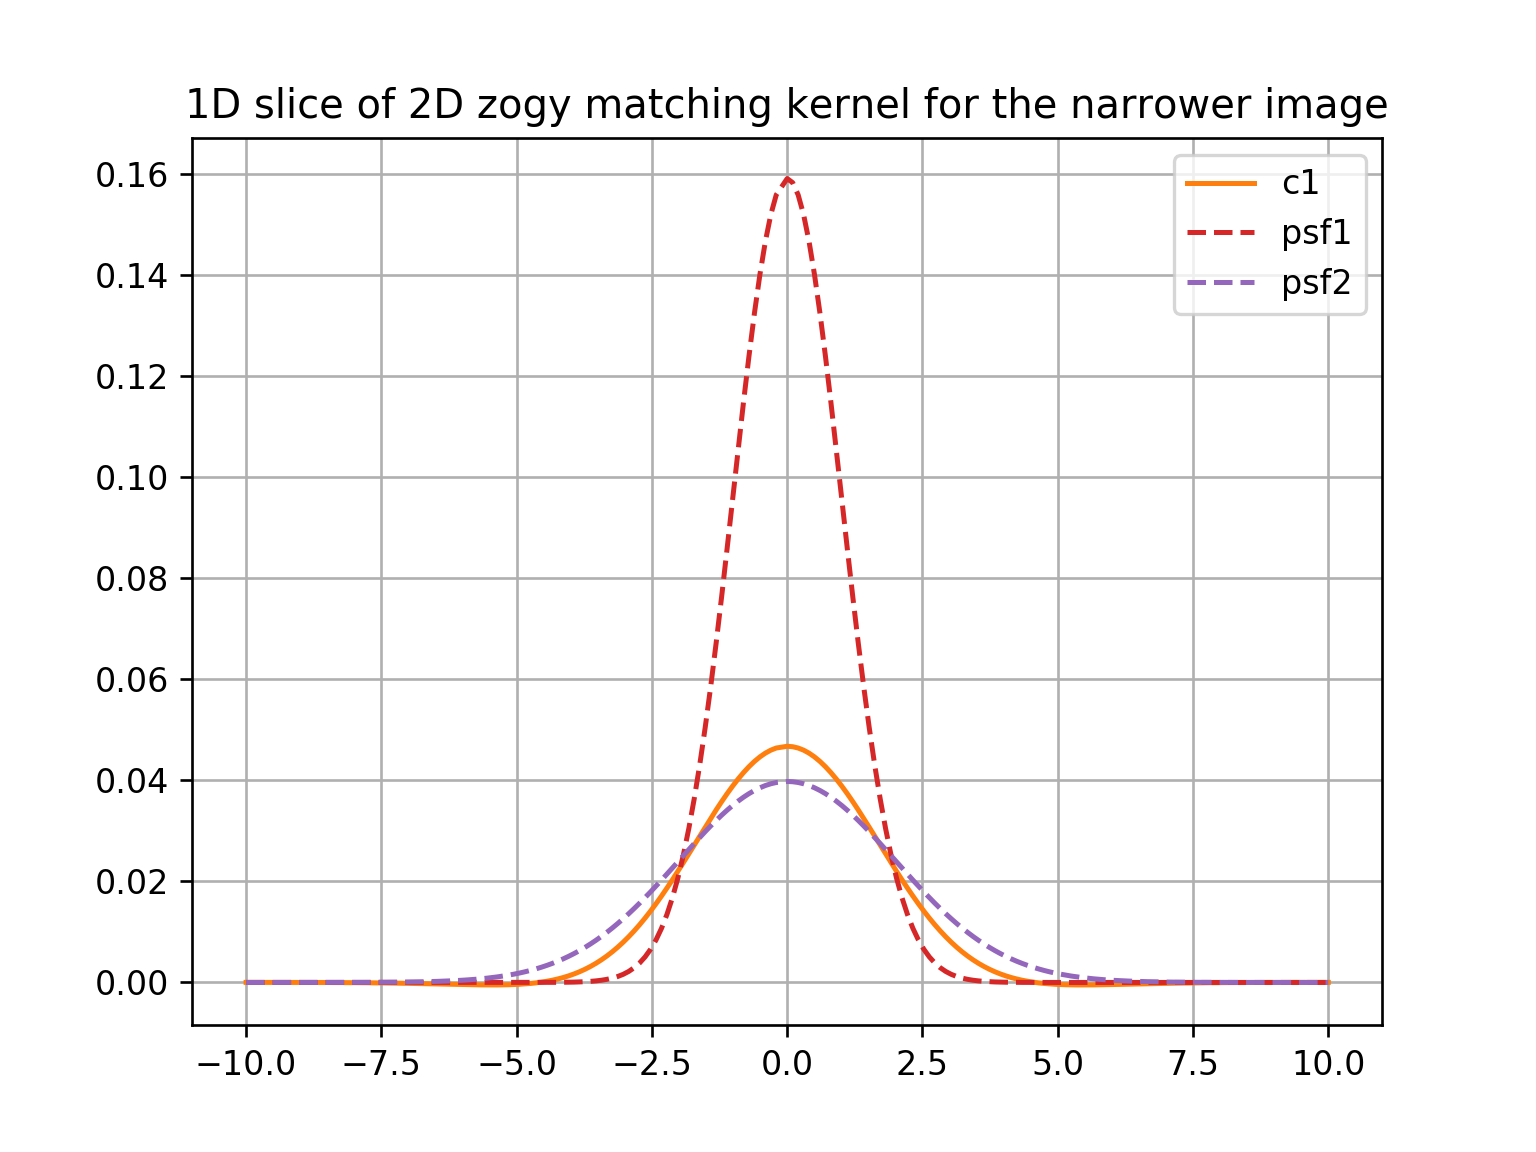

Text(0.5, 1.0, '1D slice of 2D zogy matching kernel for the narrower image')

In [26]:
# Show the (inverse) Fourier transformed 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(W2, D2, '-', color='C1', label='c1')
ax.plot(W2, r1(W2)*r1(0), '--', color='C3', label='psf1')
ax.plot(W2, r2(W2)*r2(0), '--', color='C4', label='psf2')
ax.legend()
ax.grid()
ax.set_title("1D slice of 2D zogy matching kernel for the narrower image")

In [27]:
fig.savefig("zogy_theo_Gaussians_img_c1.pdf")

<IPython.core.display.Javascript object>


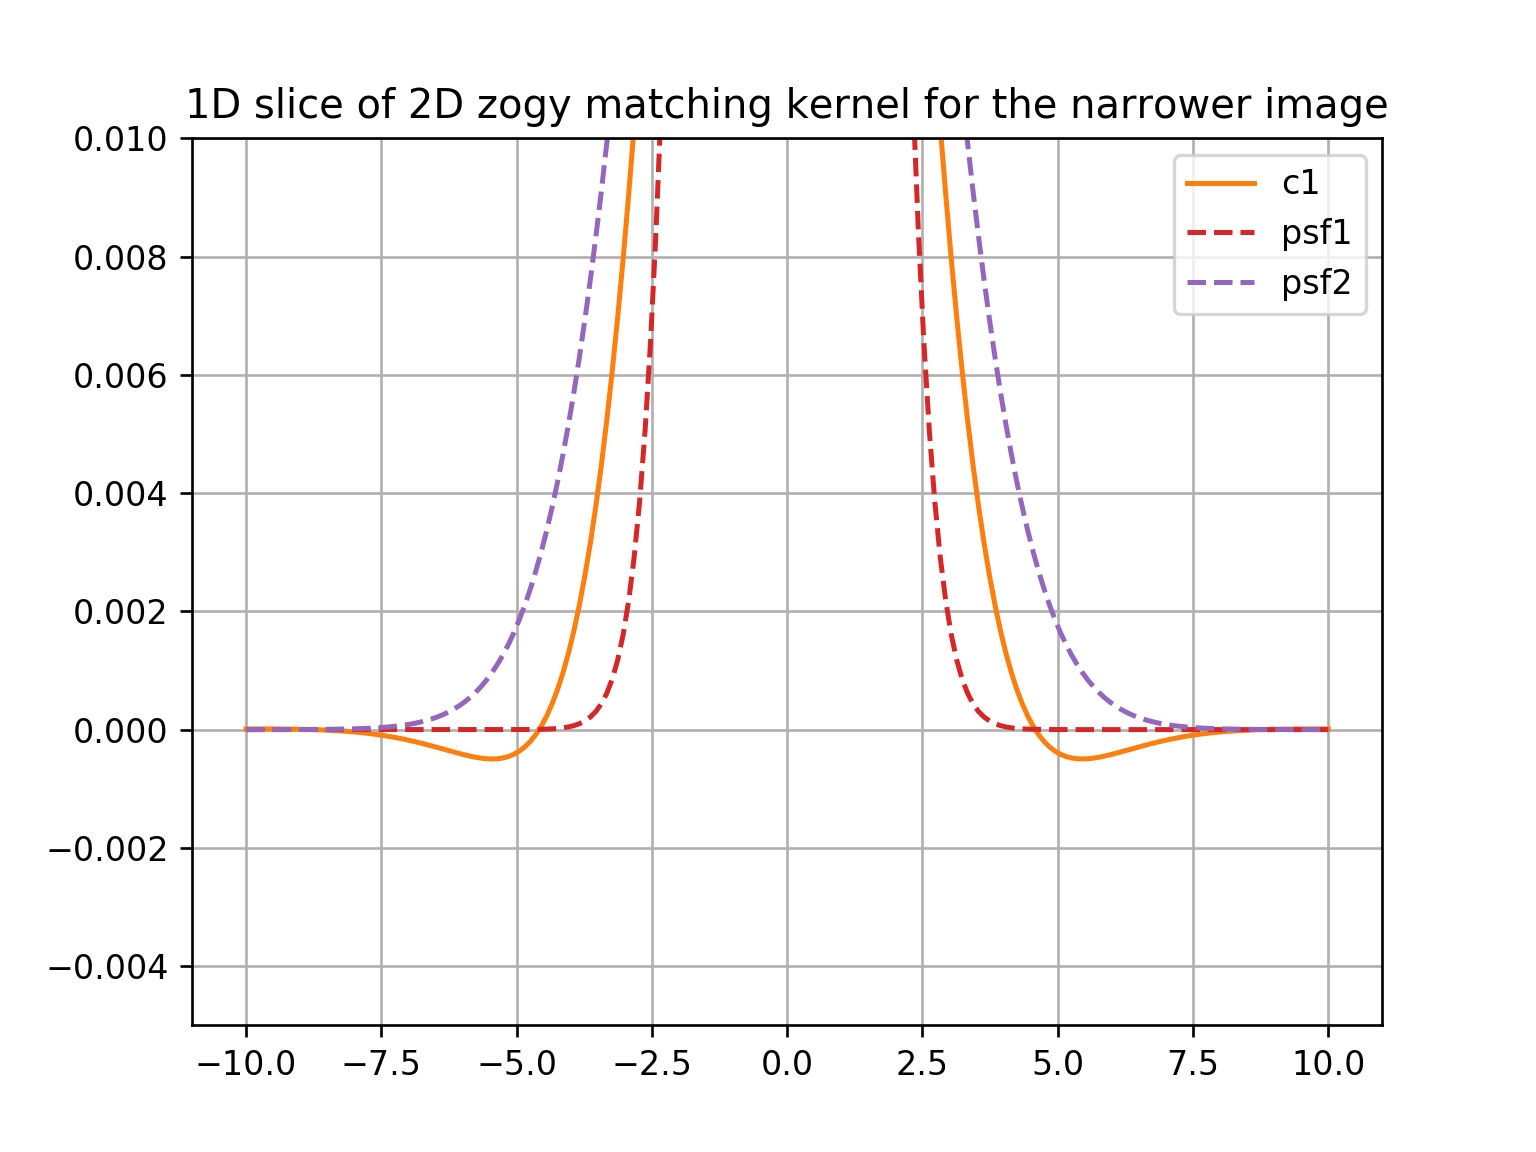

Text(0.5, 1.0, '1D slice of 2D zogy matching kernel for the narrower image')

In [28]:
# Show the (inverse) Fourier transformed 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(W2, D2, '-', color='C1', label='c1')
ax.plot(W2, r1(W2)*r1(0), '--', color='C3', label='psf1')
ax.plot(W2, r2(W2)*r2(0), '--', color='C4', label='psf2')
ax.legend()
ax.set_ylim(-0.005, 0.01)
ax.grid()
ax.set_title("1D slice of 2D zogy matching kernel for the narrower image")

In [29]:
fig.savefig("zogy_theo_Gaussians_img_c1_tails.pdf")

### c2

In [30]:
# The (inverse) Fourier-transform that we want to calculate only at k_y = 0
# The function is symmetric -> only the cosine term matters (exp(1j*x) = cos(x) + 1j*sin(x))
# The numerical integration fails at 0 where there is a dirac delta; let's subtract the dirac delta
def c21d(y, x, k_x):
    # Constant -1 is the dirac delta in Fourier space
    return np.cos(2*np.pi*k_x*x)*(1/np.sqrt(df21(x)**2 * df21(y)**2 + 1) - 1)
W = np.linspace(0.1, 10, 100)
D = [s_int.dblquad(lambda y, x:c21d(y, x, w), -10, 10, -10, 10)[0] for w in W]

In [35]:
# Let's have a negative side as well
W2 = np.concatenate((-W[::-1], [0], W))
D2 = np.concatenate((D[::-1], [1], D))

<IPython.core.display.Javascript object>


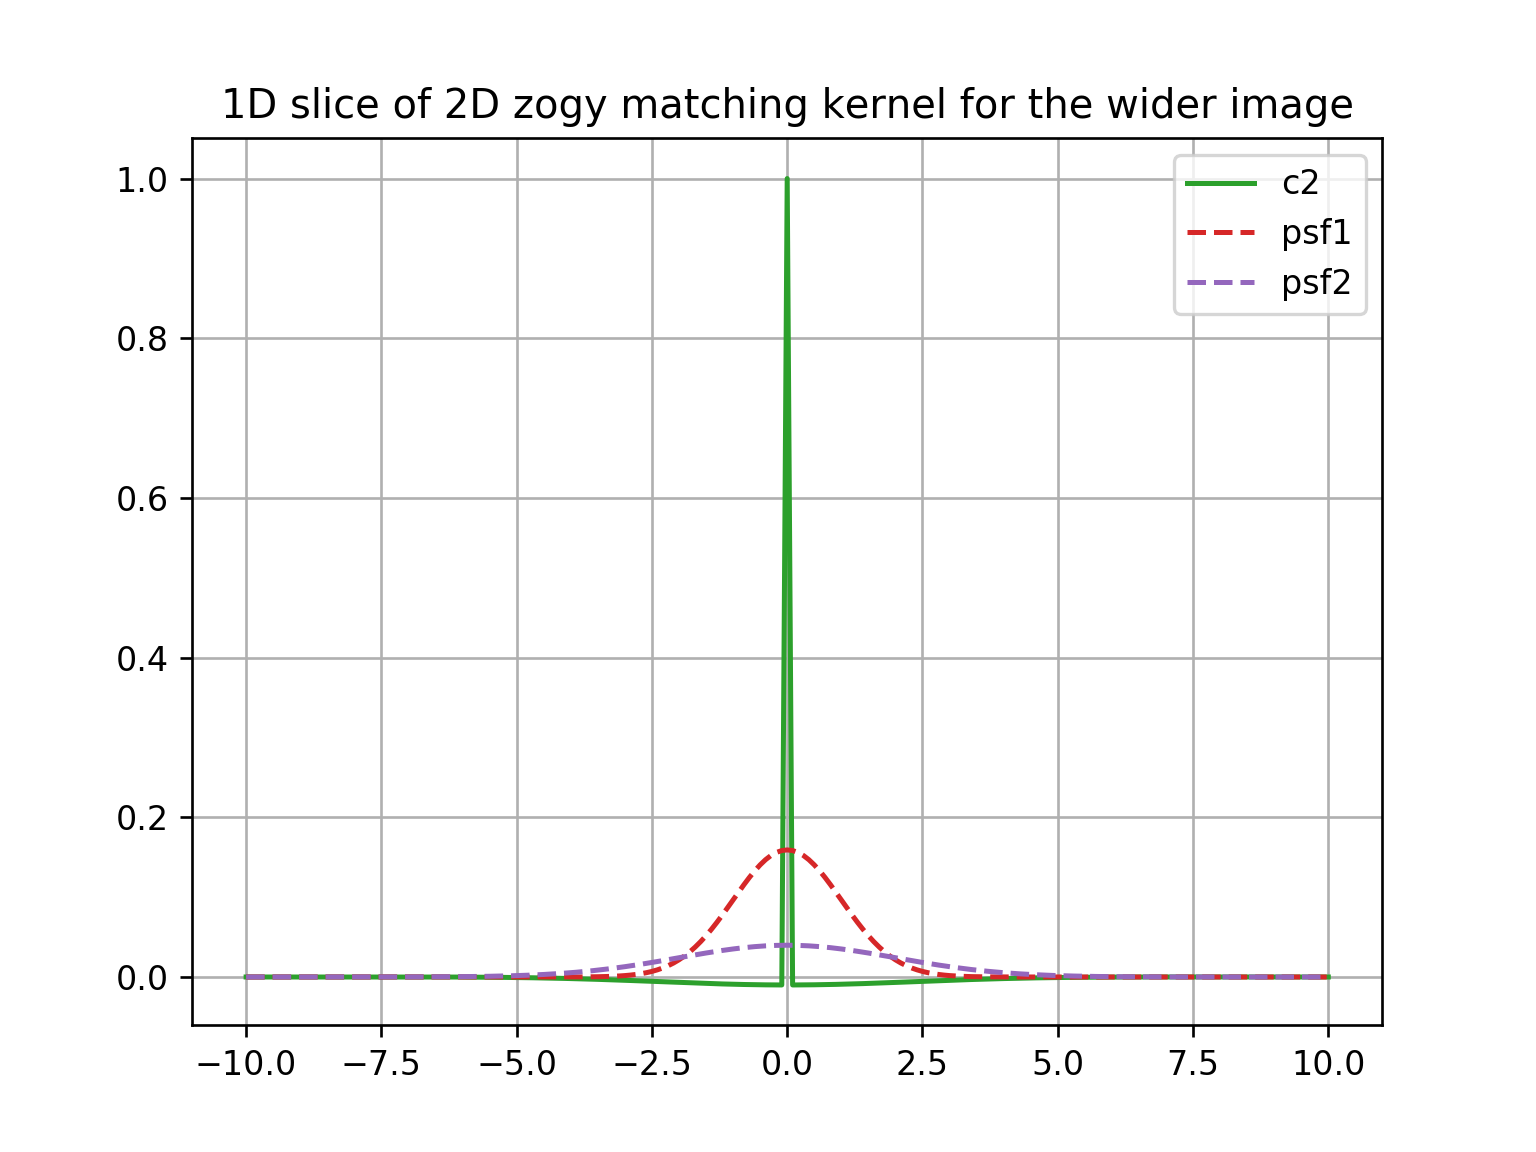

Text(0.5, 1.0, '1D slice of 2D zogy matching kernel for the wider image')

In [38]:
# Show the (inverse) Fourier transformed 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(W2, D2, '-', color='C2', label='c2')
#ax.plot([-0.1, 0, 0.1], [0, 1, 0], '-', label='c2 delta at 0' )
ax.plot(W2, r1(W2)*r1(0), '--', color='C3', label='psf1')
ax.plot(W2, r2(W2)*r2(0), '--', color='C4', label='psf2')
ax.legend()
ax.grid()
ax.set_title("1D slice of 2D zogy matching kernel for the wider image")

In [39]:
fig.savefig("zogy_theo_Gaussians_img_c2.pdf")

<IPython.core.display.Javascript object>


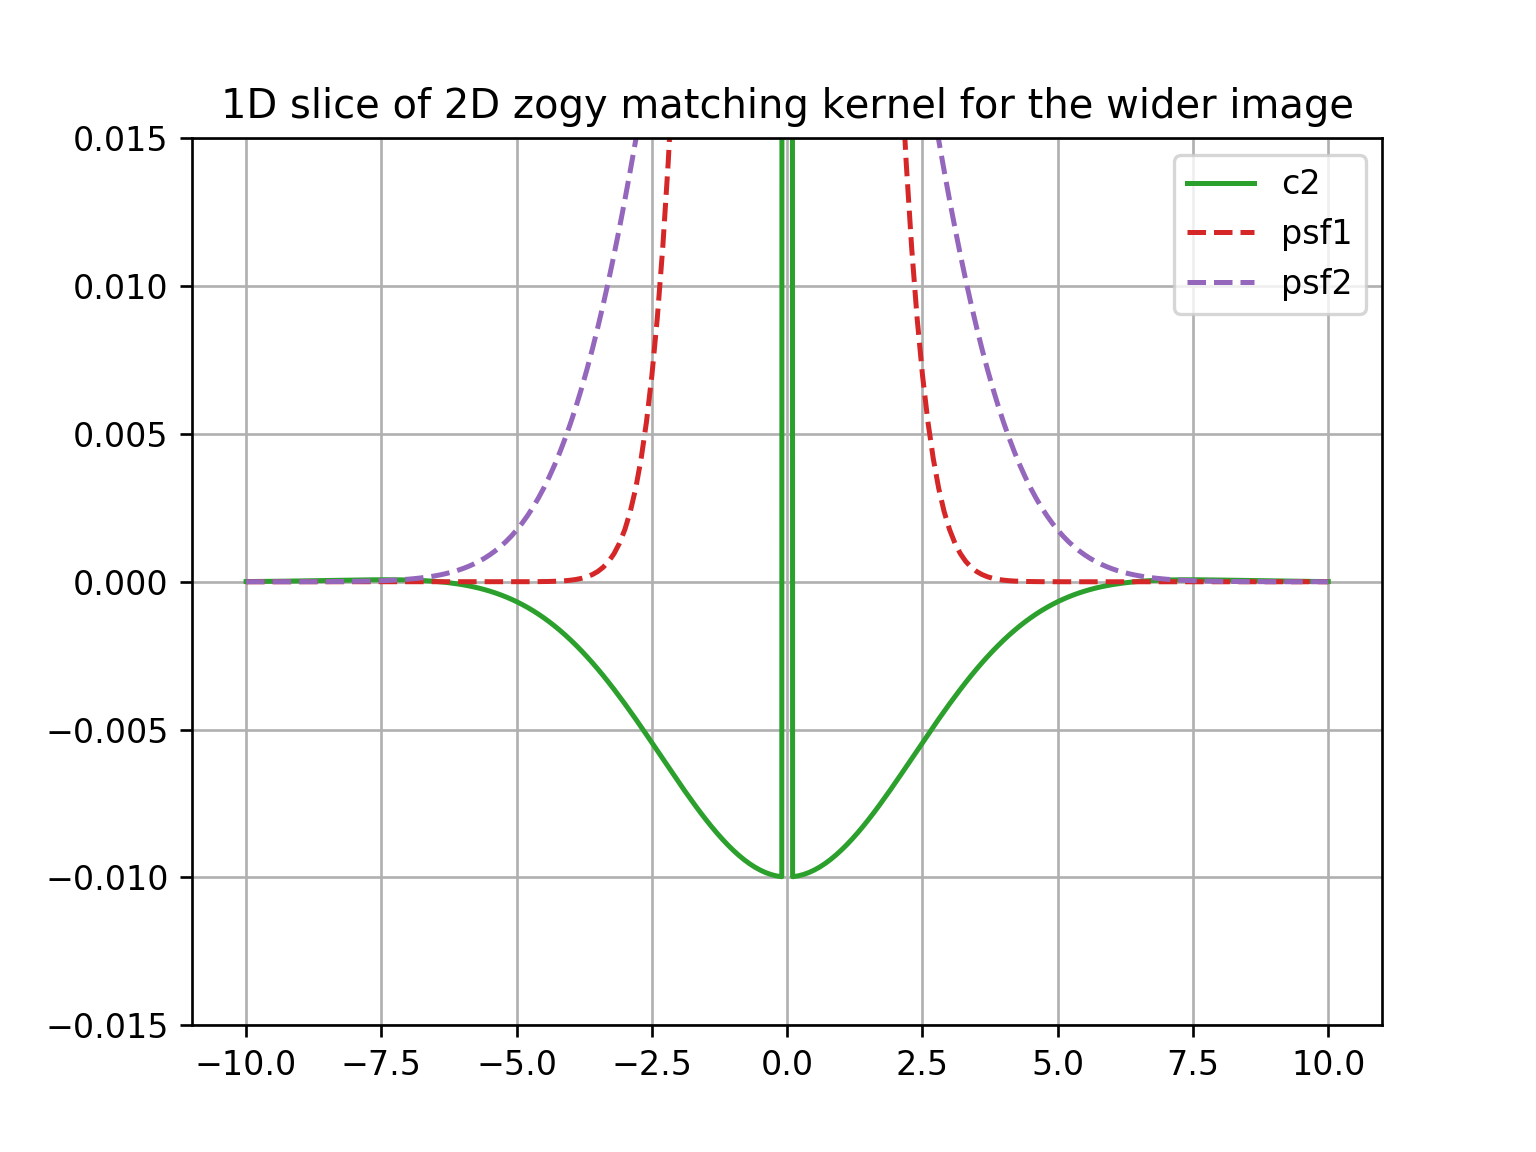

Text(0.5, 1.0, '1D slice of 2D zogy matching kernel for the wider image')

In [46]:
# Show the (inverse) Fourier transformed 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(W2, D2, '-', color='C2', label='c2')
#ax.plot([-0.1, 0, 0.1], [0, 1, 0], '-', label='c2 delta at 0' )
ax.plot(W2, r1(W2)*r1(0), '--', color='C3', label='psf1')
ax.plot(W2, r2(W2)*r2(0), '--', color='C4', label='psf2')
ax.legend()
ax.set_ylim(-0.015, 0.015)
ax.grid()
ax.set_title("1D slice of 2D zogy matching kernel for the wider image")

In [44]:
fig.savefig("zogy_theo_Gaussians_img_c2_tails.pdf")